In [23]:
import numpy as np
import random
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from scipy.optimize import minimize, fsolve
from scipy.special import gamma, erf
from scipy.stats import pearsonr, poisson
from regression import *

warnings.filterwarnings("ignore")

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 150,
    "savefig.dpi": 150,
    "figure.figsize": (8, 6),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)

In [24]:
def kd_to_ddg(kd_mut, kd_ref):
    """Calculates the change in free energy from a reference to a mutant."""
    R = 0.001987  # gas constant (kcal/(mol*K))
    T = 310  # temperature (K)
    dg_ref = -R * T * np.log(kd_ref)
    dg_mut = -R * T * np.log(kd_mut)
    ddg = round(dg_ref - dg_mut, 3)
    return ddg


def MSE(x, y):
    """Calculates mean square error of arrays x and y"""
    se = [(x - y) ** 2 for x, y in zip(x, y)]
    mse = np.mean(se)
    return round(mse, 3)


def hill(x, kd, fmax):
    """Hill Equation"""
    B = 350
    return fmax * x / (kd + x) + B


def mean_fluor_func(sigma, Fg, sort_frac, ER):
    f_bar_i = np.exp(
        sigma**2 / 2
        + np.log(Fg)
        - sigma * np.sqrt(2) * erfinv(1 - sort_frac * 2 ** (ER + 1))
    )
    return round(f_bar_i, 2)


def calc_mean_fluor(sigma, Fg, sort_frac, ER):
    fbars = [mean_fluor_func(sigma, Fg[i], sort_frac[i], ER[i]) for i in range(len(Fg))]
    return fbars


def Fbar_func(**k):
    """A: variant dependent maximum fluorescence encoded in units of RFU."""
    Fbar = (k["Fmax"] - k["B"]) * k["Ck"] / (k["Kd"] + k["Ck"]) + k["B"]
    return max(Fbar, k["B"])


def pijk_func(**k):
    """Calculates probability of cell of variant i being sorted into bin j at label concentration k."""
    pijk = (1 - k["error_rate"]) * (
        0.5
        * erf(
            (np.log(k["Hj"]) - np.log(k["Fbar"]) + 0.5 * (k["sigma"] ** 2))
            / (k["sigma"] * np.sqrt(2))
        )
        - 0.5
        * erf(
            (np.log(k["Gj"]) - np.log(k["Fbar"]) + 0.5 * (k["sigma"] ** 2))
            / (k["sigma"] * np.sqrt(2))
        )
    ) + k["error_rate"]
    return pijk


def calc_Fbar(**k):
    """Calculate the average fluorescence value given variant Kd and maximum fluorescence (Fmax)."""
    Fbar_ik = [
        Fbar_func(Kd=k["Kd"], Fmax=k["Fmax"], B=k["B"], Ck=k["Ck"][i])
        for i in range(len(k["Ck"]))
    ]
    return Fbar_ik


def calc_pijk(**k):
    """Calculates the probability that a given variant will be sorted into a bin with fluorescence bounds Hj and Gj."""
    assert len(k["Fbar"]) == len(k["Hj"]) == len(k["Gj"])
    pijk_array = [
        pijk_func(
            Fbar=k["Fbar"][i],
            Hj=k["Hj"][i],
            Gj=k["Gj"][i],
            sigma=k["sigma"],
            error_rate=k["error_rate"],
        )
        for i in range(len(k["Fbar"]))
    ]
    return pijk_array


def plot_reconstruction(kd, Fmax, Ck, mf, variant, textstr):
    c = np.logspace(0, 6, 200)
    y = [hill(conc, kd, Fmax) for conc in c]  # kd*1000
    plt.plot(c, y)
    sns.scatterplot(x=Ck, y=mf)
    props = dict(boxstyle="round", alpha=0.5, edgecolor="black")
    plt.text(kd, 0.99, textstr, fontsize=16, verticalalignment="bottom", bbox=props)
    plt.xlabel("Concentration (nM)")
    plt.ylabel(r"$\bar{F_i}$")
    plt.xscale("log")
    plt.title(variant)
    plt.tight_layout()
    # plt.savefig("plots/plot"+str(variant)+".png")
    plt.show()
    plt.clf()


def run_reg_barcodes(
    input_df,
    bc,
    conc_to_ignore,
    sigma,
    B,
    kd_guesses,
    fmax_guesses,
    top25_only=False,
    highmid_only=False,
    plot=False,
    print_df=False,
):
    bcs, kds, fmaxs, counts, concs, sf, ers, avg_counts, variants, mean_fs = (
        [] for _ in range(10)
    )

    if top25_only:
        bc_df = input_df[
            (input_df["Barcode"] == bc)
            & (~input_df["Concentration"].isin(conc_to_ignore))
            & (input_df["Bin"] == "top25")
        ].copy()
    elif highmid_only:
        bc_df = input_df[
            (input_df["Barcode"] == bc)
            & (~input_df["Concentration"].isin(conc_to_ignore))
            & (
                (input_df["Bin"] == "top25")
                | ((input_df["Bin"] == "next25") & (input_df["Concentration"] > 99))
            )
        ].copy()
    else:
        bc_df = input_df[
            (input_df["Barcode"] == bc)
            & (~input_df["Concentration"].isin(conc_to_ignore))
        ].copy()

    if print_df:
        print(bc_df)

    if len(bc_df) == 0:
        return None

    # convert to list and extract to variables
    bc_df = bc_df.to_dict("list")
    rijk = bc_df[
        "Rijk"
    ]  # number of reads of variant i in bin j at labeling concentration k
    rjk = bc_df["Rjk"]  # number of reads of bin j at labeling concentration k
    rir = bc_df["F_barcode"][0] * bc_df["Rjk"][0]
    Hj = bc_df["Hj"]  # fluorescence upper bound
    Gj = bc_df["Gj"]  # fluorescence lower bound
    Ck = bc_df["Concentration"]  # labeling concentration
    fi = bc_df["F_barcode"][0]  # reference frequency (float)
    variant = bc_df["Mutations"][0]
    sorting_frac = [njk / nk for njk, nk in zip(bc_df["Njk"], bc_df["Nk"])]

    initial_guesses = [[k, f] for k, f in zip(kd_guesses, fmax_guesses)][0]
    bounds = [(1, 2000), (5000, 90000)]

    sf.append([round(i, 2) for i in sorting_frac])
    counts.append(rijk)
    avg_counts.append(np.mean(rijk))
    concs.append(Ck)
    bcs.append(bc)
    variants.append(variant)
    er = [round(np.log2((ri / rj) / fi), 2) for ri, rj in zip(rijk, rjk)]
    ers.append(er)
    mean_f = calc_mean_fluor(sigma, Gj, sorting_frac, er)
    mean_fs.append(mean_f)

    # Unweighted fit
    popt, pcov = curve_fit(hill, Ck, mean_f, initial_guesses, bounds=bounds)
    perr = np.sqrt(np.diag(pcov))
    textstr = "\n".join(
        (
            r"$Unweighted$",
            r"$K_d=%.0f \pm %.0f nM$" % (popt[0], perr[0]),
            r"$F_{max}=%.2f \pm %.2f$" % (popt[1], perr[1]),
        )
    )
    kds.append(popt[0])
    fmaxs.append(popt[1])
    print(bc)
    if plot:
        plot_reconstruction(popt[0], popt[1], Ck, mean_f, variant, textstr)

    output_df = pd.DataFrame(
        {
            "Barcode": bcs,
            "Variant": variants,
            "Kd": kds,
            "Fmax": fmaxs,
            "Rijk": counts,
            "Concentrations": concs,
            "sorted fractions": sf,
            "ER": ers,
            "Avg_counts": avg_counts,
            "Mean_fluorescence": mean_fs,
        }
    )
    kd_wt = 100
    output_df["ddg"] = kd_to_ddg(100, kd_wt)
    return output_df

ACATGATTACTCATGGGTTC


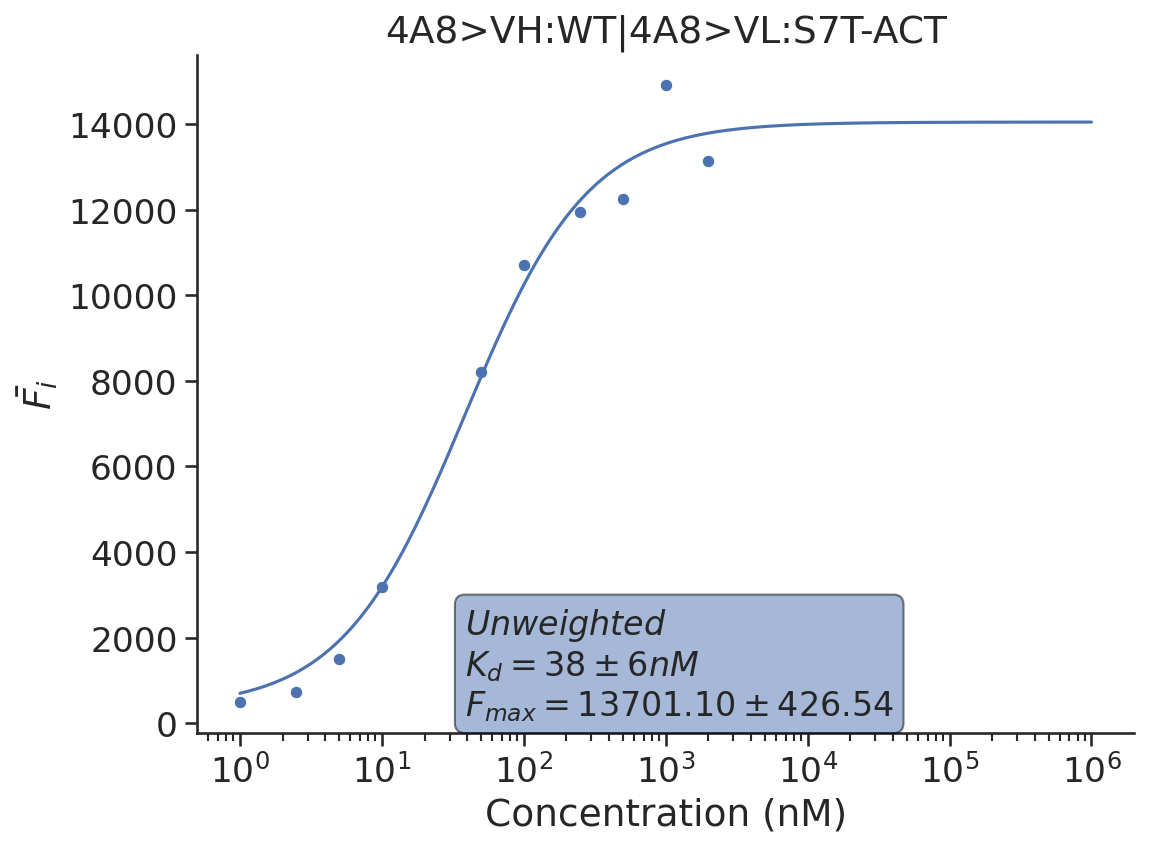

                Barcode                   Variant        Kd          Fmax  \
0  ACATGATTACTCATGGGTTC  4A8>VH:WT|4A8>VL:S7T-ACT  38.47002  13701.101758   

                                        Rijk  \
0  [84, 95, 87, 99, 102, 95, 90, 33, 64, 51]   

                                      Concentrations  \
0  [1.0, 2.5, 5.0, 10.0, 50.0, 100.0, 250.0, 500....   

                                    sorted fractions  \
0  [0.19, 0.19, 0.2, 0.25, 0.19, 0.18, 0.17, 0.19...   

                                                  ER  Avg_counts  \
0  [-0.52, -0.71, -0.5, -0.43, -0.11, -0.36, -0.5...        80.0   

                                   Mean_fluorescence  ddg  
0  [488.78, 735.75, 1487.68, 3190.83, 8216.51, 10...  0.0  


<Figure size 1200x900 with 0 Axes>

In [28]:
# Input parameters
sigma = 1.02
B = 350
kd_guesses = [50, 100, 200]
fmax_guesses = [40000, 30000, 25000]
conc_to_ignore = [0, 25]

bcs = [
    "TAGGACATCCGTAATTGTGG",
    "ACATGATTACTCATGGGTTC",
    "ATATGTAGCAATCTATCAAC",
    "CCGTCCTCATTTCCTTCTGT",
    "ATGCCTTCCTGGGTGGGTAC",
    "ACATATTCAAAGACGGCAGG",
    "TAGTAATTAAGTGATTCAAC",
    "ATGCACACATTTAAAGCTGT",
    "ACAGGCATGAATAATTATGG",
    "AAACCTACATTGCAAGGCTC",
    "ATTGCTGTGCGCGAATAATT",
    "TCGTCCATGATGGAAGCTTG",
    "ATGTATTTGTATCCTCGAGC",
    "TATGATGGCAACGTGTAATT",
    "CCATACATGCAGGAAGCAGC",
]

input_df = pd.read_csv(
    "/projects/brpe7306/fab-library-barcoding/Match_all/_combined.csv"
)
input_df.sort_values(by=["Concentration"], inplace=True)

# Run regression
output = run_reg_barcodes(
    input_df,
    bcs[1],
    conc_to_ignore,
    sigma=sigma,
    B=B,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    top25_only=True,
    highmid_only=False,
    plot=True,
    print_df=False,
)
print(output)

Variant           object
Rijk             float64
Hj                 int64
Gj                 int64
Nk               float64
Njk              float64
Rjk              float64
fi               float64
ref_counts         int64
ref_total          int64
Concentration    float64
Bin               object
dtype: object
     Variant  Rijk     Hj    Gj         Nk       Njk       Rjk        fi  \
1       R59*   4.0  83893  7008  1105021.0  250000.0  255111.0  0.000235   
21      H60*  43.0  83893  7008  1105021.0  250000.0  255111.0  0.001170   
41      F61*  10.0  83893  7008  1105021.0  250000.0  255111.0  0.001048   
61      I62*  13.0  83893  7008  1105021.0  250000.0  255111.0  0.000087   
81      R79*   9.0  83893  7008  1105021.0  250000.0  255111.0  0.000811   
...      ...   ...    ...   ...        ...       ...       ...       ...   
5310   L159*   7.0   9871   524  2643089.0  250000.0  273353.0  0.000155   
5330   A160*  12.0   9871   524  2643089.0  250000.0  273353.0  0.000562   
53

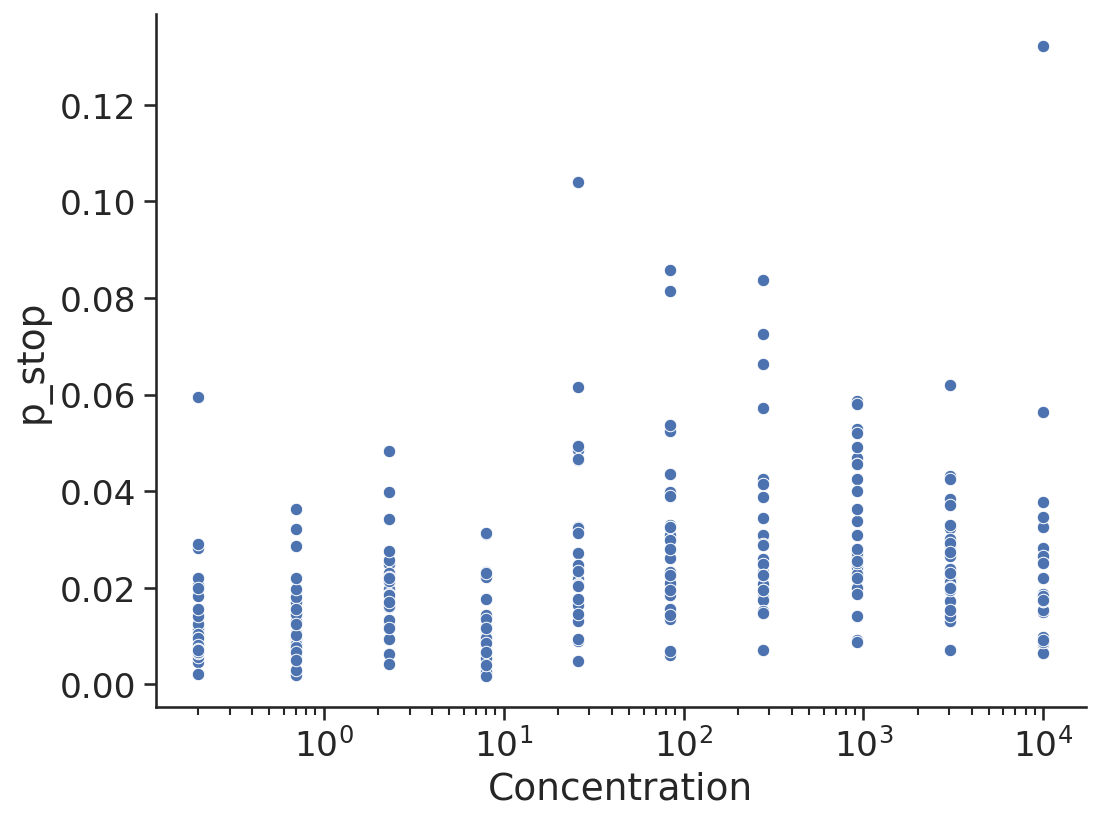

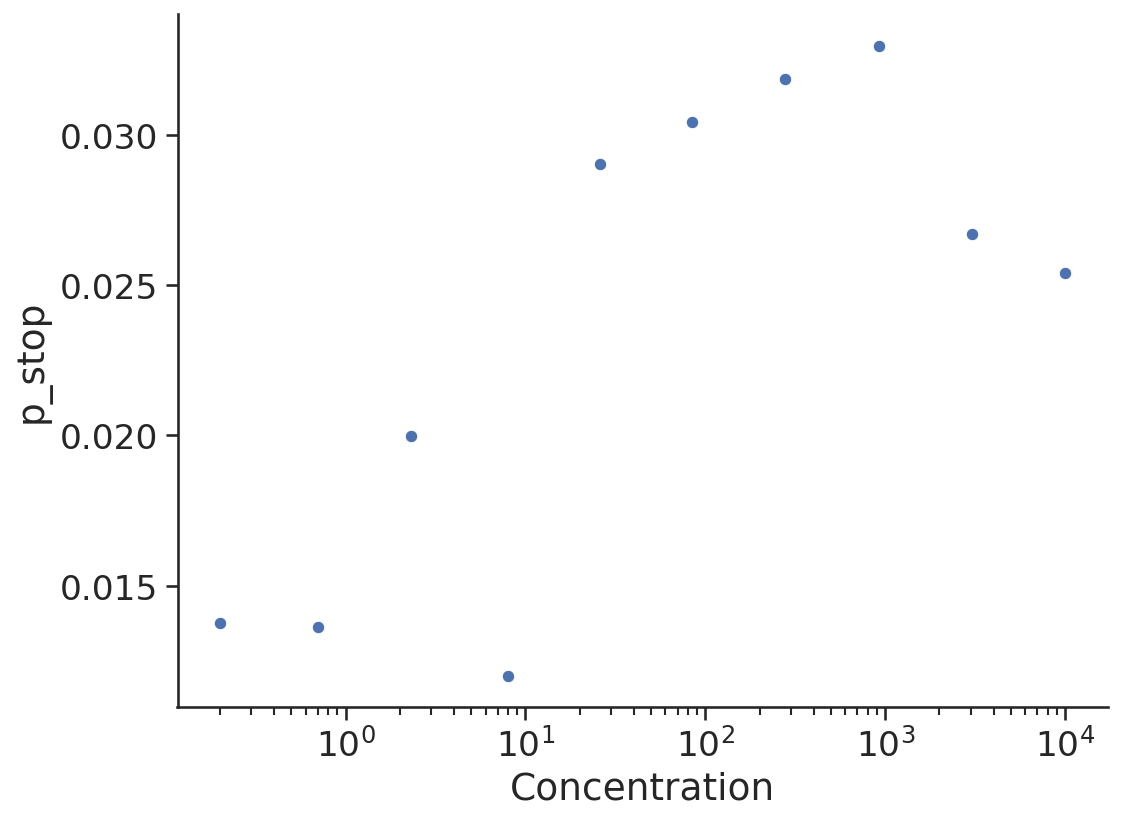

In [22]:
# Sorting error estimation based on stop codons
df = pd.read_csv(
    "/projects/brpe7306/fab-library-barcoding/MLE/repB_mandi_titration_100nM-HAB_allref_new.csv",
    dtype={"Njk": float, "Nk": float, "Rijk": float, "Rjk": float},
)
print(df.dtypes)
df = df[df["Variant"].str.contains("\*")]
df["p_stop"] = (df["Njk"] / df["Nk"]) * (df["Rijk"] / df["Rjk"]) / df["fi"]
print(df)
print(df["p_stop"].mean())
mean_vals = df.groupby("Concentration", as_index=False)["p_stop"].mean()
print(mean_vals)
sns.scatterplot(x="Concentration", y="p_stop", data=df)
plt.xscale("log")
plt.show()
sns.scatterplot(x="Concentration", y="p_stop", data=mean_vals)
plt.xscale("log")
plt.show()